In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, RocCurveDisplay, average_precision_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
SPLITS = [
    [str(i) for i in range(1, 23) if i % 2 == 1] + ["X"],
    [str(i) for i in range(1, 23) if i % 2 == 0] + ["Y"],
]
cols = ["chrom", "pos", "ref", "alt"]
dataset_path = "results/eqtl/matched/leafcutter"
SPLITS

[['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X'],
 ['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']]

In [3]:
models = [
    #"CADD.RawScore",
    "phyloP",
    #"phastCons",
    #"phyloP-Zoonomia",
    "SpliceAI",
    #"multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

embedding_models = [
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species",
    "LongSafari/hyenadna-large-1m-seqlen-hf",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
]

model_renaming = {
    "CADD.RawScore": "CADD",
    "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA",
    "phyloP": "phyloP-100-vertebrates",
    "phastCons": "phastCons-100-vertebrates",
    "phyloP-Zoonomia": "phyloP-241-mammals",
    "InstaDeepAI/nucleotide-transformer-2.5b-multi-species": "NT",
    "LongSafari/hyenadna-large-1m-seqlen-hf": "HyenaDNA",
    "multiz100way/89/256/128/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True": "GPN-MSA-256",
}

V = pd.read_parquet(f"../../{dataset_path}/test.parquet")
d = Path(f"../../results/preds/{dataset_path}")
for m in models:
    model_name = model_renaming.get(m, m)
    model_path = d / f"{m}.parquet"
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates,SpliceAI
0,1,690060,A,C,0.994126,0.038760,True,0,-0.144,NaN
1,1,727717,G,C,0.001489,0.180818,False,90,-0.058,NaN
2,1,792461,G,A,0.008431,0.054545,False,383,-0.679,NaN
3,1,794299,C,G,0.009810,0.229965,False,720,1.256,NaN
4,1,794707,T,C,0.003659,0.053030,False,330,-0.894,NaN
...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,0.163,-0.0
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-0.000,NaN
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-0.127,NaN
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.000,NaN


In [4]:
features = {}

for m in embedding_models:
    df = pd.read_parquet(f"../../results/preds/vep_embedding/{dataset_path}/{m}.parquet")
    df.columns = model_renaming.get(m, m) + "_" + df.columns
    if m == "SpliceAI": df = -df.abs()
    features[model_renaming.get(m, m)] = df.columns.values
    V = pd.concat([V, df], axis=1)
embedding_models = [model_renaming.get(m, m) for m in embedding_models]
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates,SpliceAI,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
0,1,690060,A,C,0.994126,0.038760,True,0,-0.144,NaN,...,266.441467,287.110992,146.383179,275.987885,158.766785,154.002899,348.674530,405.518036,276.017761,138.900818
1,1,727717,G,C,0.001489,0.180818,False,90,-0.058,NaN,...,52.585453,213.585419,407.643860,198.342026,107.811081,78.725189,421.376099,447.695007,138.069580,196.668915
2,1,792461,G,A,0.008431,0.054545,False,383,-0.679,NaN,...,261.180298,322.555969,96.627724,262.574402,179.089859,153.717194,424.171448,262.439911,302.829041,194.546494
3,1,794299,C,G,0.009810,0.229965,False,720,1.256,NaN,...,249.778137,193.264816,117.372139,175.490295,56.533432,134.306625,241.691681,388.020294,134.707825,198.264587
4,1,794707,T,C,0.003659,0.053030,False,330,-0.894,NaN,...,253.927078,237.712952,99.033936,206.052002,83.369339,188.182587,264.076355,307.015350,265.697449,190.575134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17991,X,154864799,G,A,0.009303,0.017241,False,8936,0.163,-0.0,...,207.094330,202.479736,80.969009,238.938293,98.145981,128.790253,323.611206,301.625366,323.425354,122.212959
17992,X,155329596,C,T,0.006108,0.282998,False,8822,-0.000,NaN,...,197.695175,248.423981,109.285988,276.909485,210.782898,175.647949,407.054810,342.855042,282.064423,278.325317
17993,X,155655744,G,A,0.008496,0.291332,False,8995,-0.127,NaN,...,183.158325,509.719971,339.346069,542.251709,259.935211,205.515503,617.384399,464.768738,238.398544,67.365250
17994,X,155705325,G,A,0.007774,0.471574,False,8923,-0.000,NaN,...,179.480957,421.967163,118.363228,338.253662,162.723450,163.829620,482.696503,244.241348,295.701355,157.662903


In [5]:
exclude_abs = ["CADD", "phyloP", "phyloP-100-vertebrates", "phyloP-241-mammals", "phyloP-Zoonomia", 'phastCons-100-vertebrates']
for m in models:
    if m in V.columns and m not in exclude_abs:
        print(m)
        V[m] = -V[m].abs()

SpliceAI


In [6]:
V.dropna(
    subset=models + [features[m][0] for m in embedding_models],
    inplace=True
)
V

,chrom,pos,ref,alt,pip,maf,label,match_group,phyloP-100-vertebrates,SpliceAI,...,GPN-MSA-256_embedding_758,GPN-MSA-256_embedding_759,GPN-MSA-256_embedding_760,GPN-MSA-256_embedding_761,GPN-MSA-256_embedding_762,GPN-MSA-256_embedding_763,GPN-MSA-256_embedding_764,GPN-MSA-256_embedding_765,GPN-MSA-256_embedding_766,GPN-MSA-256_embedding_767
8,1,946870,C,A,1.000000,0.036384,True,4,0.677,-0.03,...,113.052628,160.739929,149.662979,233.486877,68.259964,101.940224,492.869293,500.302185,108.170540,188.496826
9,1,954496,C,G,0.996345,0.015265,True,5,0.338,-0.00,...,151.393219,235.822678,185.708694,203.959595,66.364120,129.256531,435.541718,459.078125,118.636581,265.431824
10,1,958339,G,A,0.955819,0.092703,True,6,1.424,-0.00,...,207.950928,171.378876,129.910431,198.144409,73.214630,123.845863,392.341736,351.938416,102.407784,166.002655
11,1,973443,G,A,0.999930,0.164754,True,7,0.262,-0.02,...,116.171761,272.188232,122.652672,135.252502,88.660217,108.346146,348.310669,382.899689,163.719406,251.818298
12,1,973693,C,T,0.994036,0.368690,True,8,1.827,-0.02,...,114.584854,242.845062,150.129089,151.327316,82.521896,102.917374,292.800903,437.744904,154.134171,239.674347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17980,X,153874994,C,T,0.998931,0.266917,True,8988,-0.499,-0.00,...,179.952164,190.322769,108.294373,113.851768,58.162861,165.370697,289.945862,329.138794,178.676849,275.905212
17986,X,154477925,C,G,0.906906,0.163367,True,8994,0.989,-0.00,...,124.848907,225.502991,116.993271,143.125519,162.684021,143.683609,363.284271,390.077545,246.016022,268.521545
17989,X,154842829,G,C,0.009303,0.017241,False,8819,-0.089,-0.00,...,197.207794,513.360535,258.533508,477.037994,226.778625,293.439819,547.213989,457.156555,163.174225,73.434998
17990,X,154843392,C,T,0.009303,0.017241,False,8835,-0.076,-0.00,...,206.018311,481.989899,328.246460,532.833496,237.231354,249.095901,598.662781,511.957794,225.285400,66.851257


In [7]:
V = V[V.duplicated("match_group", keep=False)]
V.label.value_counts()

label
True     3233
False    3233
Name: count, dtype: int64

In [8]:
def train_predict_best_inner_product(V_train, V_test, features):
    results_train = pd.DataFrame([
        [f, roc_auc_score(V_train.label, -V_train[f])]
        for f in tqdm(features)
    ], columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
    sorted_indices = results_train.Model.values
    return V_test[sorted_indices[0]]

def train_predict_lr(V_train, V_test, features):
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('linear', LogisticRegressionCV(
            random_state=42,
            scoring="roc_auc",
            n_jobs=-1,
            max_iter=1000,
            Cs=np.logspace(-5, 0, 10),
        ))
    ])
    clf.fit(V_train[features], V_train.label)
    linear = clf.named_steps["linear"]
    C = linear.C_
    Cs = linear.Cs_
    if C == Cs[0] or C == Cs[-1]:
        raise Exception(f"{C=} {Cs[0]=} {Cs[-1]=}")
    return -clf.predict_proba(V_test[features])[:, 1]

supervised_models = []

for m in embedding_models:
    #supervised_models.append((
    #    f"{m} - best inner product",
    #    lambda *args, m=m: train_predict_best_inner_product(*args, features[m]),
    #))
    supervised_models.append((
        f"{m} - LR(inner products)",
        lambda *args, m=m: train_predict_lr(*args, features[m]),
    ))

#supervised_models.append((
#    f"GPN-MSA + Enformer - LR(inner products+abs(delta features))",
#    lambda *args: train_predict_lr(*args, np.concatenate([features["GPN-MSA"], features["Enformer"]])),
#))

for split in SPLITS:
    print(split)
    mask_train = V.chrom.isin(split)
    mask_test = ~mask_train
    for model_name, model in supervised_models:
        print(model_name)
        if model_name not in models: models.append(model_name)
        V.loc[mask_test, model_name] = model(V[mask_train], V[mask_test])

['1', '3', '5', '7', '9', '11', '13', '15', '17', '19', '21', 'X']
GPN-MSA - LR(inner products)
NT - LR(inner products)
HyenaDNA - LR(inner products)
GPN-MSA-256 - LR(inner products)
['2', '4', '6', '8', '10', '12', '14', '16', '18', '20', '22', 'Y']
GPN-MSA - LR(inner products)
NT - LR(inner products)
HyenaDNA - LR(inner products)
GPN-MSA-256 - LR(inner products)


## Testing

In [9]:
def get_subtitle(n_pathogenic, n_benign):
    return f"n={n_pathogenic} vs. {n_benign}"

pos_prop = []

rows = []
V_c = V
n_pos, n_neg = (V_c.label==True).sum(), (V_c.label==False).sum()
subtitle = get_subtitle(n_pos, n_neg)
pos_prop.append(n_pos/(n_pos+n_neg))

for m in tqdm(models):
    AUROC = roc_auc_score(V_c.label==True, -V_c[m])
    rows.append([m, AUROC])
results = pd.DataFrame(rows, columns=["Model", "AUROC"]).sort_values("AUROC", ascending=False)
results

100%|██████████| 6/6 [00:00<00:00, 193.04it/s]


,Model,AUROC
5,GPN-MSA-256 - LR(inner products),0.753338
3,NT - LR(inner products),0.749412
2,GPN-MSA - LR(inner products),0.748966
4,HyenaDNA - LR(inner products),0.699651
1,SpliceAI,0.642420
0,phyloP-100-vertebrates,0.514957


In [10]:
#results.to_parquet("results_sqtl.parquet", index=False)

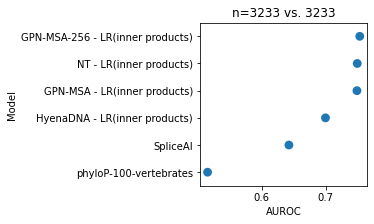

In [11]:
plt.figure(figsize=(3,3))
sns.pointplot(
    data=results.replace({
        "Enformer_l2": "Enformer",
        "GPN-MSA": "GPN-MSA (LLR)",
    }),
    y="Model",
    x="AUROC",
    join=False,
)
plt.title(subtitle);